In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [3]:
def _calculate_kappa(k1, k2, psi):
    """
    Calculate kappa from k1 and k2
    """
    return np.sqrt(2 * ((k1 * np.cos(psi))**2 + (k2 * np.sin(psi))**2))

In [4]:
"""
The equations from this point on reference the simulation paper.
"""

def E_kappa(kappa: float, L2D: float, c: float) -> float:
    """
    Calculates the energy spectrum in terms of kappa = sqrt(2(k1^2cos^2psi + k2^2sin^2psi))
    """
    numerator = c * (kappa**3)
    denominator = (L2D**(-2) + kappa**2)**(7/3)

    return numerator / denominator

def E_kappa_attenuated(kappa: float, L2D: float, z_i: float, c: float) -> float:
    """
    Attenuated energy spectrum in terms of kappa
    """
    return E_kappa(kappa, L2D, c) / (1 + (kappa * z_i)**2)

In [10]:
def __spectral_tensor_common(kappa: float, L2D: float, z_i: float, c: float, k: float, use_k: bool = False) -> float:
    """
    Common leading factor for each spectral tensor component
    """
    energy = E_kappa_attenuated(kappa, L2D, z_i, c)

    denom = (np.pi * kappa) if not use_k else (np.pi * k)

    return energy / denom

def __spectral_tensor_unattenuated_common(kappa: float, L2D: float, c: float, k: float, use_k: bool = False) -> float:
    """
    Common leading factor for each spectral tensor component

    This is for the unattenuated energy spectrum
    """

    return E_kappa(kappa, L2D, c) / (np.pi * k)

def sim_spectral_tensor_11(
    k1: float,
    k2: float,
    L2D: float,
    z_i: float,
    c: float,
    psi: float,
    attenuated: bool = True,
    use_k: bool = False
) -> float:
    """
    Simulated spectral tensor with energy spectrum in kappa

    Use attenuated to control attenuation/not

    This is for the 11 component
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)

    leading_factor = __spectral_tensor_common(
        kappa, L2D, z_i, c, k, use_k
    ) if attenuated else __spectral_tensor_unattenuated_common(
        kappa, L2D, c, k, use_k
    )

    projection = 1 - (k1 / k)**2

    return leading_factor * projection


def sim_spectral_tensor_22(
    k1: float, 
    k2: float, 
    L2D: float, 
    z_i: float, 
    c: float, 
    psi: float, 
    attenuated: bool = True,
    use_k: bool = False
) -> float:
    """
    Simulated spectral tensor with energy spectrum in kappa

    Use attenuated to control attenuation/not

    This is for the 22 component
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)

    leading_factor = __spectral_tensor_common(kappa, L2D, z_i, c, k, use_k) if attenuated else __spectral_tensor_unattenuated_common(kappa, L2D, c, psi)

    projection = 1 - (k2 / k)**2

    return leading_factor * projection

In [11]:
import warnings


def eq6_numerical_F11_2D(
    k1: float,
    psi: float,
    L2D: float,
    z_i: float,
    c: float,
    attenuated: bool = True,
    use_k: bool = True
):
    """
    Implements equation 6 to obtain F11
    """

    res, err = integrate.quad(
        lambda k2: sim_spectral_tensor_11(k1, k2, L2D, z_i, c, psi, attenuated, use_k),
        -np.inf, np.inf,
    )
    
    return res, err

def eq6_numerical_F22_2D(
    k1: float,
    psi: float,
    L2D: float,
    z_i: float,
    c: float,
    attenuated: bool = True,
    use_k: bool = True
):
    """
    Implements equation 6 to obtain F22
    """

    res, err = integrate.quad(
        lambda k2: sim_spectral_tensor_22(k1, k2, L2D, z_i, c, psi, attenuated, use_k),
        -np.inf, np.inf,
    )

    return res, err

Average error with attenuation: 0.0000000000
Average error without attenuation: 0.0000000131
Max error with attenuation: 0.0000000000
Max error without attenuation: 0.0000000131
L2 norm with attenuation: 0.0000000000
L2 norm without attenuation: 0.0000000131


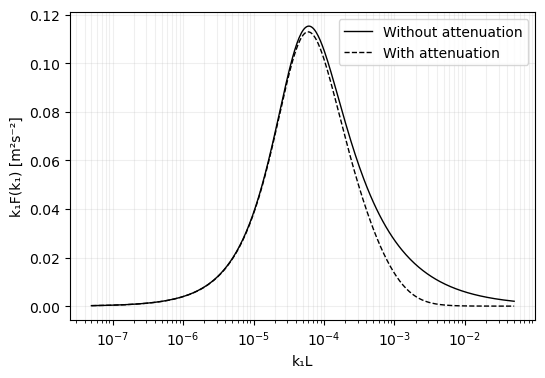

In [ ]:
"""
This cell aims to recreate Figure 1 in the theory paper.
"""

plt.clf(); plt.close('all');

L2D = 20_000 # km
z_i = 500 # m
psi = np.deg2rad(43)

c = 1e-3

k1 = np.logspace(-3, 3, 400) / L2D

############################################
# Collect the two arrays and resp errors

atten_err_list = []
unatten_err_list = []

numerical_F11_attenuated = []
numerical_F11_unattenuated = []

for _k1 in k1:
    atten_res, atten_err = eq6_numerical_F11_2D(_k1, psi, L2D, z_i, c, attenuated=True)
    unatten_res, unatten_err = eq6_numerical_F11_2D(_k1, psi, L2D, z_i, c, attenuated=False)

    atten_err_list.append(atten_err)
    unatten_err_list.append(unatten_err)

    numerical_F11_attenuated.append(_k1 * atten_res)
    numerical_F11_unattenuated.append(_k1 * unatten_res)

############################################
# Print some basic stats for the integration errors

print(f"Average error with attenuation: {np.mean(atten_err):.10f}")
print(f"Average error without attenuation: {np.mean(unatten_err):.10f}")

print(f"Max error with attenuation: {np.max(atten_err):.10f}")
print(f"Max error without attenuation: {np.max(unatten_err):.10f}")

print(f"L2 norm with attenuation: {np.linalg.norm(atten_err):.10f}")
print(f"L2 norm without attenuation: {np.linalg.norm(unatten_err):.10f}")

############################################
# Plot

plt.figure(figsize=(6, 4))

plt.plot(k1 * L2D, numerical_F11_unattenuated, "-", color="black", label="Without attenuation", linewidth=1)
plt.plot(k1 * L2D, numerical_F11_attenuated, "--", color="black", label="With attenuation", linewidth=1)
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

Average error for (a) F11: 0.0000154762
Average error for (a) F22: 153.2881011141
Max error for (a) F11: 0.0001365742
Max error for (a) F22: 5053.0830650185
L2 norm for (a) F11: 0.0007123442
L2 norm for (a) F22: 13920.9918304961


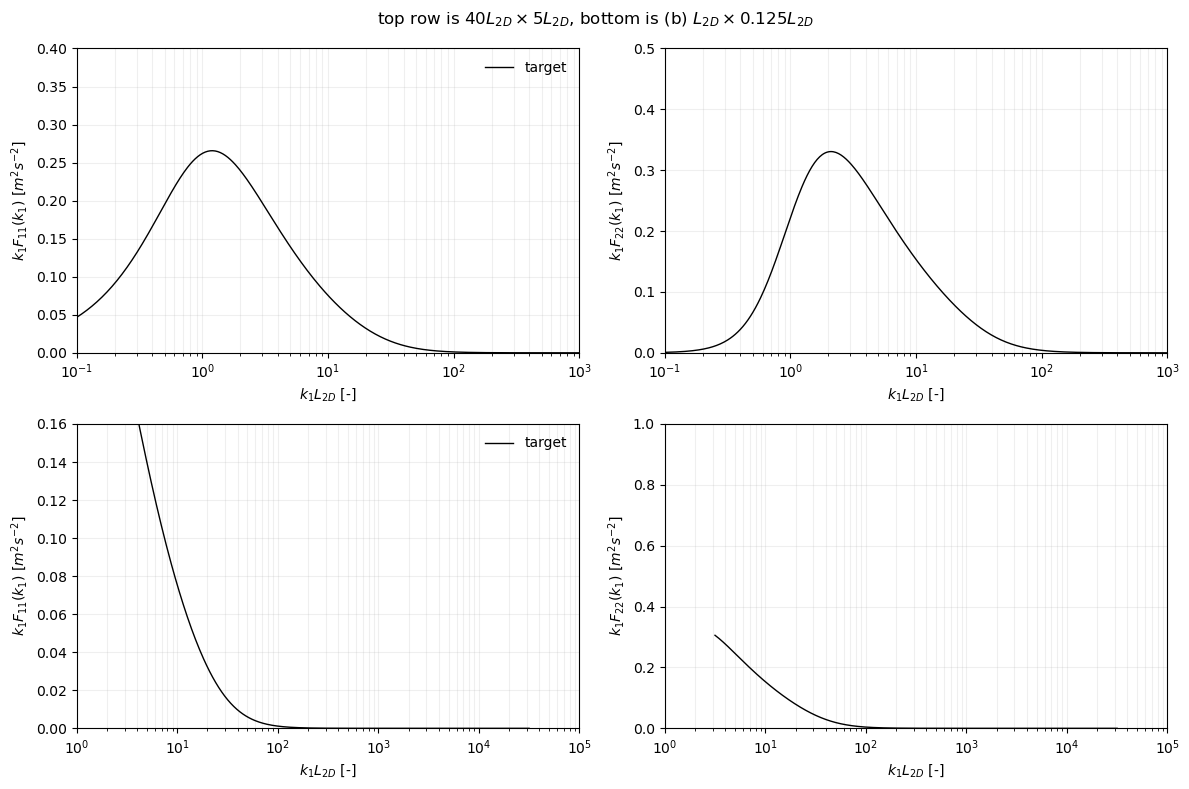

In [14]:
plt.clf(); plt.close('all');

# Parameters
L2D = 20_000 # m
sigma2 = 2 # (m/s)^2
z_i = 500 # m
psi = np.deg2rad(45)

c = (8 * sigma2) / (9 * (L2D**(2/3)))

warnings.filterwarnings("ignore")

########################################################################
# Domain setup


# grab subplots, then helper for subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

def setup_subplots(ax, ylim, is_F11 = True, is_a = True):
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="-", alpha=0.2)
    ax.set_xlabel("$k_1 L_{2D}$ [-]")
    ax.set_ylabel("$k_1 F(k_1)$ [m²s⁻²]")

    if is_F11:
        ax.set_ylabel("$k_1 F_{11}(k_1)$ $[m^2s^{-2}]$")
    else:
        ax.set_ylabel("$k_1 F_{22}(k_1)$ $[m^2s^{-2}]$")

    if is_a:
        ax.set_xlim(1e-1, 1e3)
    else:
        ax.set_xlim(1e0, 1e5)

    ax.set_ylim(0, ylim)

#######################################################################
# (a) Top plots - 40L2D x 4L2D domain

k1_arr_a = np.logspace(-1, 3, 400) / L2D


# Collect the arrays
numerical_F11_a = []
numerical_F22_a = []

numerical_F11_err_a = []
numerical_F22_err_a = []

for k1 in k1_arr_a:
    f11_res, f11_err = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    f22_res, f22_err = eq6_numerical_F22_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)

    numerical_F11_a.append(k1 * f11_res)
    numerical_F22_a.append(k1 * f22_res)

    numerical_F11_err_a.append(f11_err)
    numerical_F22_err_a.append(f22_err)


# Print error stats
print(f"Average error for (a) F11: {np.mean(numerical_F11_err_a):.10f}")
print(f"Average error for (a) F22: {np.mean(numerical_F22_err_a):.10f}")

print(f"Max error for (a) F11: {np.max(numerical_F11_err_a):.10f}")
print(f"Max error for (a) F22: {np.max(numerical_F22_err_a):.10f}")

print(f"L2 norm for (a) F11: {np.linalg.norm(numerical_F11_err_a):.10f}")
print(f"L2 norm for (a) F22: {np.linalg.norm(numerical_F22_err_a):.10f}")

ax1.plot(k1_arr_a * L2D, numerical_F11_a, "-", color="black", label="target", linewidth=1)
setup_subplots(ax1, 0.4, is_F11=True, is_a=True)
ax1.legend(frameon=False)

ax2.plot(k1_arr_a * L2D, numerical_F22_a, "-", color="black", label="target", linewidth=1)
setup_subplots(ax2, 0.5, is_F11=False, is_a=True)

#######################################################################
# (b) Bottom plots - L2D x 0.125L2D domain

k1_arr_b = np.logspace(0.5, 4.5, 400) / L2D
numerical_F11_b = []
numerical_F22_b = []

for k1 in k1_arr_b:
    f11_res, _ = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    f22_res, _ = eq6_numerical_F22_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)

    numerical_F11_b.append(k1 * f11_res)
    numerical_F22_b.append(k1 * f22_res)

ax3.plot(k1_arr_b * L2D, numerical_F11_b, "-", color="black", label="target", linewidth=1)
setup_subplots(ax3, 0.16, is_F11=True, is_a=False)
ax3.legend(frameon=False)

ax4.plot(k1_arr_b * L2D, numerical_F22_b, "-", color="black", label="target", linewidth=1)
setup_subplots(ax4, 1.0, is_F11=False, is_a=False)

#########################################################################
# Overall plot edits
fig.suptitle(r"top row is $40L_{2D}\times 5L_{2D}$, bottom is (b) $L_{2D} \times 0.125L_{2D}$", y=0.98)
plt.tight_layout()
plt.show()

warnings.filterwarnings("default")
